In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from datetime import datetime
import pickle

In [3]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# Predictive performance on regression and classification datasets

The predictive performance for regression and classification tasks is evaluated using the HS datasets. Similar to the experiment design used by (Abhineet et al. 2022) we evaluate the performance for each RF version for different degrees of model complexity. In our study we grow each random forest with a fixed number of trees d, for several choices of $d\in{15,\ 25,\ 50,\ 100}$. In contrast to the original experiment design, we do not incorporate ensembles with less than 15 trees as they do not yield OOB samples for all training observations and exclude ensembles with 200 trees due to the long computation time of our artifact. The predictive performance of each model is computed and averaged over 10 random splits of the test data.

## Run experiment

The code for the experiment is implemented in the script `Run_PredPerf_experiment`, so it can be run in the background and be parallelized. 
To rerun the experiment you have to copy the command and paste it into the terminal. After execution the scripts will run in the background and the results will be stored as pickle files under `data/pred_perf_experiment`.

In [ ]:
##Run experiment for all HS classification datasets and store results as pickle 
#nohup Run_PredPerf_experiment &

In [ ]:
##Run experiment for all HS regression datasets and store results as pickle 
#nohup Run_PredPerf_experiment --DS_number 0 1 2 3 4 --model_type regression --scoring_func r2_score &

## Load results

In [4]:
# Get all files 
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","pred_perf_experiment")
data_path_clf = os.path.join(data_path, "classification")
data_path_reg = os.path.join(data_path, "regression")

In [8]:
# Define order for datasets
dsets_name_clf = ["heart", "breast-cancer", "haberman", "diabetes", "german-credit"]
dsets_name_reg = ["friedman1", "friedman2", "friedman3", "abalone", "diabetes-regr"]

In [9]:
# Get path for all pickle files in classification folderws
pkl_clf = [None] * len(dsets_name_clf)
valid_type = [".pickle",".pkl"]

for f in os.listdir(data_path_clf):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_type:
        continue
    name = f.split("_")[0]
    idx = dsets_name_clf.index(name)
    pkl_clf[idx] = os.path.join(data_path_clf,f)

In [10]:
# Get path for all pickle files in regression folderws
pkl_reg = [None] * len(dsets_name_reg)
valid_type = [".pickle",".pkl"]

for f in os.listdir(data_path_reg):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_type:
        continue
    name = f.split("_")[0]
    idx = dsets_name_reg.index(name)
    pkl_reg[idx] = os.path.join(data_path_reg,f)

In [11]:
# Load clf pickle files
res_clf = {}
for name, i in zip(dsets_name_clf, pkl_clf):
    with open(i, "rb") as input_file:
        res_clf[name]=pickle.load(input_file)

In [12]:
# Load reg pickle files
res_reg = {}
for name, i in zip(dsets_name_reg, pkl_reg):
    with open(i, "rb") as input_file:
        res_reg[name]=pickle.load(input_file)

## Create plots

In [13]:
def create_perf_plot(res_exp, ax=None, show_legend=False, show_ylabel=True):
    """Create performance comparison plot for one experiment"""
    
    if ax==None:
        fig, ax = plt.subplots(1,1, figsize=(7,5))
    
    model_names_gridcv = ['RF', 'HsRF', 'AugHS_smSHAP', 'AugHS_mse'] # for retrieving resultss from experiment
    dset_name = res_exp["data"]["dataset_name"]
    model_type = vars(res_exp["simulation_settings"])["model_type"]
    n_trees = vars(res_clf["heart"]["simulation_settings"])["n_trees_list"]
    X = res_exp["data"]["X"]
    
    mu = []
    sem = []
    
    # Store mean and sem for each model 
    for i in model_names_gridcv:
        mu.append(res_exp[i]["scores"].mean(axis=1))
        sem.append(res_exp[i]["sem"])
    
    # Create plot
    ax.errorbar(x=n_trees, y=mu[0], yerr=sem[0], alpha=.5, linewidth=3, marker="o", label="RF")
    ax.errorbar(x=n_trees, y=mu[1], yerr=sem[1], alpha=.5, linewidth=3, marker="o", label="HsRF")
    ax.errorbar(x=n_trees, y=mu[2], yerr=sem[2], alpha=.5, linewidth=3, marker="o", label="AugHsRF smSHAP")
    ax.errorbar(x=n_trees, y=mu[3], yerr=sem[3], alpha=.5, linewidth=3, marker="o", label="AugHsRF MSE")        
    
    ax.set_title(f"{dset_name} (n = {X.shape[0]}, p = {X.shape[1]})")
    ax.set_xlabel("Number of Trees")
    
    if show_ylabel:
        y_label = "AUC" if model_type=="classification" else "R2"
        ax.set_ylabel(y_label)
    
    if show_legend:
        ax.legend()

### Classification

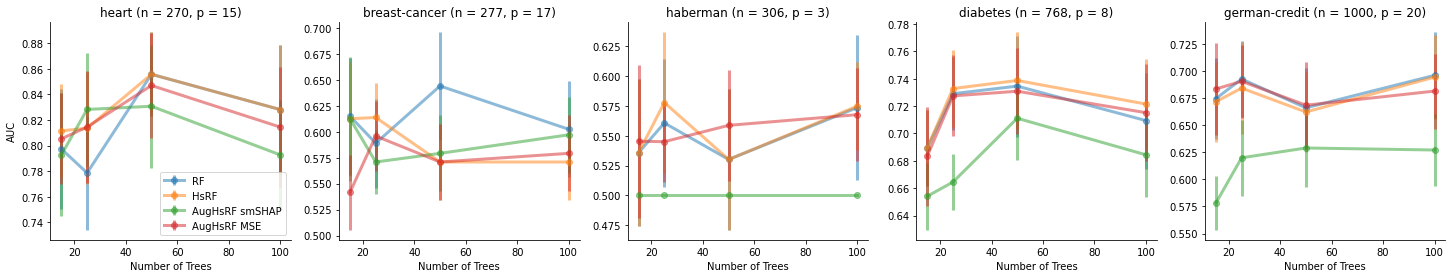

In [14]:
# Create plots classsification
model_names_gridcv = ['RF', 'HsRF', 'AugHS_smSHAP', 'AugHS_mse'] # for retrieving resultss from experiment

fig, axs = plt.subplots(1,5, figsize=(25,4))

for i, exp in enumerate(dsets_name_clf):
    if i == 0:
        create_perf_plot(res_clf[exp], axs[i], show_legend=True, show_ylabel=True) #show legend on first plot
        continue
    create_perf_plot(res_clf[exp], axs[i], show_legend=False, show_ylabel=False)

In [116]:
# Save figure
fig.savefig(f"{data_path_clf}/clf_plots.png")

### Regression

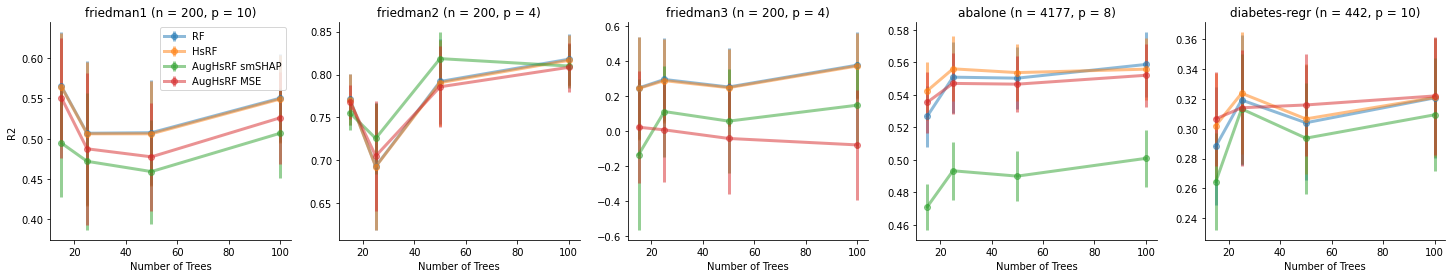

In [15]:
# Create plots regression
model_names_gridcv = ['RF', 'HsRF', 'AugHS_smSHAP', 'AugHS_mse'] # for retrieving resultss from experiment

fig, axs = plt.subplots(1,5, figsize=(25,4))

for i, exp in enumerate(dsets_name_reg):
    if i == 0:
        create_perf_plot(res_reg[exp], axs[i], show_legend=True, show_ylabel=True) #show legend on first plot
        continue
    create_perf_plot(res_reg[exp], axs[i], show_legend=False, show_ylabel=False)

In [16]:
# Save figure
fig.savefig(f"{data_path_reg}/reg_plots.png")